In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from datetime import timedelta
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from time import time

In [69]:
fred_md = pd.read_csv("data/Fred_MD_Current.csv")
fred_md.drop(0,axis=0, inplace=True) #Dropping the first row because it contains the transfotmation values. For this data look at fred_md_metadata.tcode.
fred_md.set_index("sasdate", inplace=True)
fred_md_metadata = pd.read_csv("data/FRED-MD_Metadata.csv", encoding='iso-8859-1')
fred_md.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


In [70]:
fred_md_metadata.head()

,id,tcode,fred,description,gsi,gsi:description,group
0,1,5,RPI,Real Personal Income,M_14386177,PI,1
1,2,5,W875RX1,Real personal income ex transfer receipts,M_145256755,PI less transfers,1
2,3,5,DPCERA3M086SBEA,Real personal consumption expenditures,M_123008274,Real Consumption,4
3,4,5,CMRMTSPLx,Real Manu. and Trade Industries Sales,M_110156998,M&T sales,4
4,5,5,RETAILx,Retail and Food Services Sales,M_130439509,Retail sales,4


In [71]:
# 1. Time frame included in the dataset
time_frame_min = fred_md.index.min()
time_frame_max = fred_md.index.max()
print(f"Time Frame: {time_frame_min} to {time_frame_max}")
print("Number of Months:", len(fred_md))
print("")
# 2. Amount of economic variables included
num_economic_variables = len(fred_md.columns) 
print(f"Number of Economic Variables: {num_economic_variables}")
print("")
# 3. Null variables identification
null_counts = fred_md.isnull().sum()
null_variables = null_counts[null_counts > 0]
if not null_variables.empty:
    print("Columns with Null Values and their Counts:")
    print(null_variables)
else:
    print("No null variables found.")

Time Frame: 1/1/1959 to 9/1/2023
Number of Months: 780

Number of Economic Variables: 127

Columns with Null Values and their Counts:
CMRMTSPLx          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      6
S&P PE ratio       5
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         155
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64


# AR Model:

## Data Preparation

In [72]:
# Choosing AR Variable
y = "UNRATE"
fedfund = pd.Series(fred_md[y])

# Setting index to datetime and establishing monthly frequency
fedfund.asfreq(pd.infer_freq(fedfund.index),)
frequency = pd.infer_freq(fred_md.index)
fedfund.index = pd.DatetimeIndex(fred_md.index, freq=frequency)

fedfund

sasdate
1959-01-01    6.0
1959-02-01    5.9
1959-03-01    5.6
1959-04-01    5.2
1959-05-01    5.1
             ... 
2023-08-01    3.8
2023-09-01    3.8
2023-10-01    3.8
2023-11-01    3.7
2023-12-01    3.7
Freq: MS, Name: UNRATE, Length: 780, dtype: float64

In [73]:
### IDEA: Make fedfund into a monthly change of fedfund rate series series
#fedfund = fedfund.diff().fillna(0)
#fedfund

In [74]:
# Define time scope

# Get Training and Testing Set
train_end = datetime(2007,6,1)
#train_end = datetime(2018,12,1)
test_end = datetime(2019,6,1)
#test_end = datetime(2023,9,1)

train_data = fedfund[:train_end]
test_data = fedfund[train_end + timedelta(days=31):test_end]

fedfund=fedfund[:test_end]

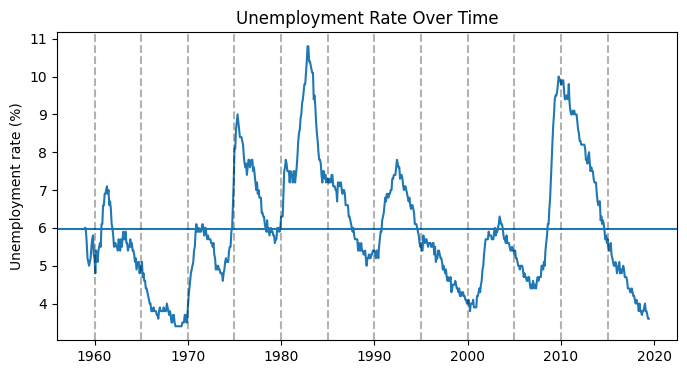

In [75]:
# Plot Time Series
plt.figure(figsize=(8,4))
plt.plot(fedfund)
plt.title("Unemployment Rate Over Time")
plt.ylabel("Unemployment rate (%)")
plt.axhline(fedfund.mean())
for year in range (fedfund.index[0].year+1,fedfund.index[-1].year +1, 5):
    plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

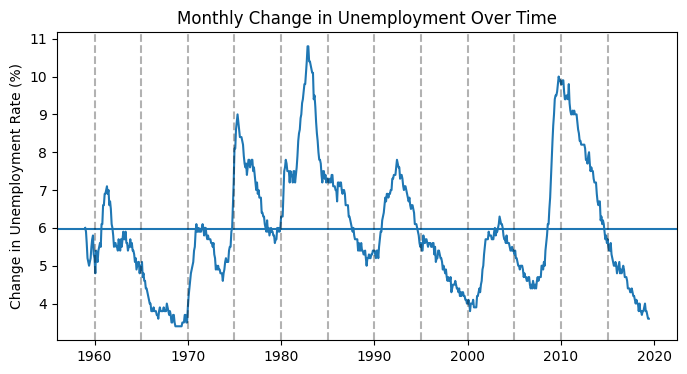

In [76]:
# Plot Time Series
plt.figure(figsize=(8,4))
plt.plot(fedfund)
plt.title("Monthly Change in Unemployment Over Time")
plt.ylabel("Change in Unemployment Rate (%)")
plt.axhline(fedfund.mean())
for year in range (fedfund.index[0].year+1,fedfund.index[-1].year +1, 5):
    plt.axvline(pd.to_datetime(str(year) +'-01-01'), color = 'k', linestyle = '--', alpha = 0.3)

In [77]:
fedfund.sort_values()

sasdate
1969-02-01     3.4
1968-09-01     3.4
1968-10-01     3.4
1968-11-01     3.4
1968-12-01     3.4
              ... 
1982-10-01    10.4
1983-01-01    10.4
1983-02-01    10.4
1982-11-01    10.8
1982-12-01    10.8
Name: UNRATE, Length: 726, dtype: float64

In [78]:
# Dickey-Fuller test to check stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(fedfund)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] > 0.05:
    print("Series is not stationary. Consider differencing or transforming the data.")
else:
    print("Series is stationary. Proceeding with AR model selection.")


ADF Statistic: -2.891801993265496
p-value: 0.046309653176428274
Critical Values: {'1%': -3.43955476721974, '5%': -2.865602155751202, '10%': -2.5689331692727135}
Series is stationary. Proceeding with AR model selection.


## ACF and PACF graphs:

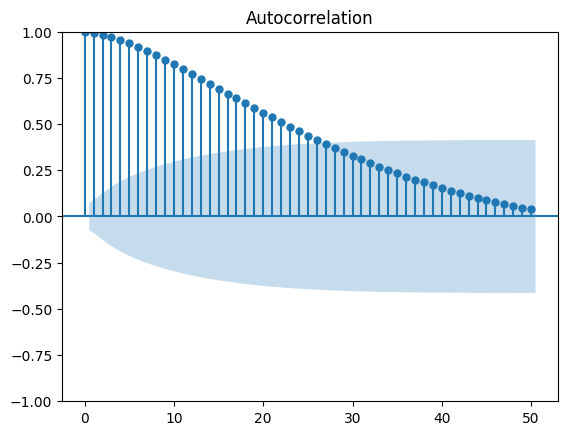

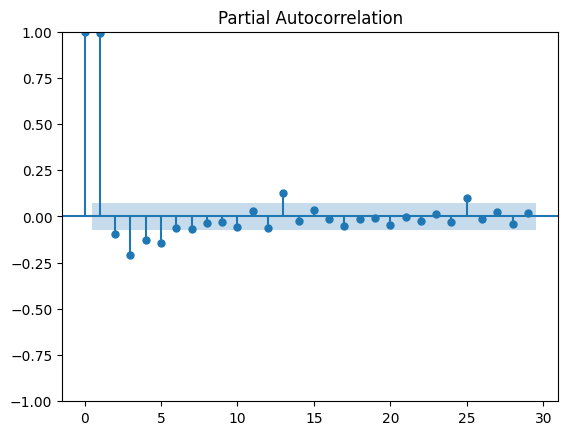

In [79]:
acf_plot = plot_acf(fedfund, lags=50)
pacf_plot = plot_pacf(fedfund)

## Non-Rolling Forecast

In [80]:
#Choose optimal lag
bic_values = []
lags = range(1, 7)  # Maximum lag of 12

for lag in lags:
    model = AutoReg(train_data, lags=lag)
    model_fitted = model.fit()
    bic_values.append(model_fitted.bic)

# Selecting the model with the lowest BIC
optimal_lag = lags[np.argmin(bic_values)]
print(f"Optimal lag length: {optimal_lag} with BIC: {min(bic_values)}")

# Create AR Model
model = AutoReg(train_data, lags=optimal_lag)
#fit the model
model_fit = model.fit()
#Model Summary
print(model_fit.summary())

Optimal lag length: 5 with BIC: -382.78140691775013
                            AutoReg Model Results                             
Dep. Variable:                 UNRATE   No. Observations:                  582
Model:                     AutoReg(5)   Log Likelihood                 213.643
Method:               Conditional MLE   S.D. of innovations              0.167
Date:                Thu, 07 Mar 2024   AIC                           -413.286
Time:                        16:57:56   BIC                           -382.781
Sample:                    06-01-1959   HQIC                          -401.391
                         - 06-01-2007                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0816      0.030      2.752      0.006       0.023       0.140
UNRATE.L1      0.9766      0.041     23.740      0.000       0.896       1.057


In [81]:
#Prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#Prediction residuals
predictions = model_fit.predict(start=pred_start_date, end = pred_end_date)
residuals = test_data - predictions

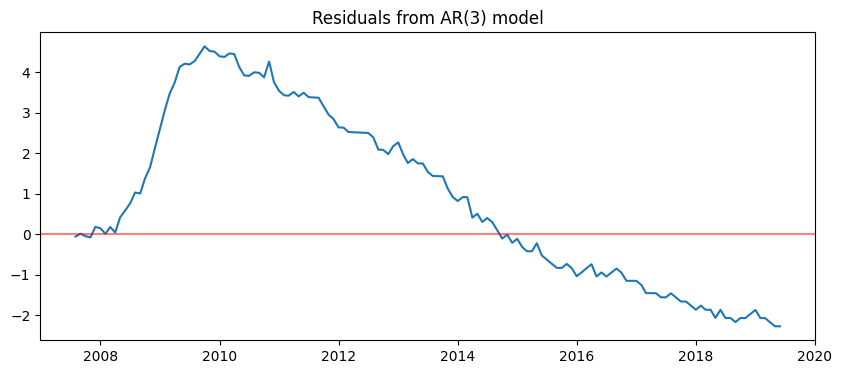

In [82]:
#Plot Residuals 
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from AR(3) model")
plt.axhline(0,color='r',alpha=0.5)
plt.show()

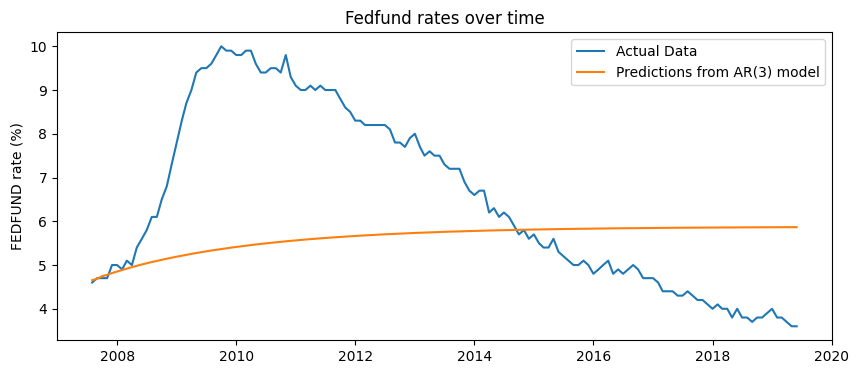

In [83]:
#Plot Predictions vs Actual 
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(("Actual Data", "Predictions from AR(3) model"))
plt.title("Fedfund rates over time")
plt.ylabel("FEDFUND rate (%)")
plt.show()

In [84]:
from sklearn.metrics import mean_absolute_error
def calculate_performance_metrics(residuals, actual):
    # Handling division by zero and missing values in actual data
    mask = actual != 0
    mean_abs_percent_error = round(np.mean(abs(residuals[mask] / actual[mask])), 4) 
    root_mean_squared_error = np.round((np.mean(residuals**2)),4)
    mae = round(np.mean(abs(residuals)), 4)
    
    return mean_abs_percent_error, root_mean_squared_error, mae

from sklearn.metrics import mean_absolute_percentage_error

In [85]:
# Performance Metrics
mape, rmse, mae = calculate_performance_metrics(residuals, test_data)
print("1-Month Horizon - MAPE:", mape, "%, RMSE:", rmse,", MAE:",mae )

1-Month Horizon - MAPE: 0.2828 %, RMSE: 5.3483 , MAE: 1.9017


## Roling Forecast Framework [1,3,6 Month Horizons]

The idea here is to create a model that take in all the data and predicts the next month.  For each date k in the test period. Train on dates 0 to k-1, and predict k.

I will run this algorithm using 1-month, 3-month and 6-month horizon


In [86]:
test_data.index[0] - pd.DateOffset(months=1)

Timestamp('2007-07-01 00:00:00')

In [87]:
#Create Model
predictions_rolling_1m = pd.Series()
predictions_rolling_3m = pd.Series()
predictions_rolling_6m = pd.Series()
predictions_rolling_12m = pd.Series()
for end_date in test_data.index:
#Prediction start and end dates
    #1month
    train_data_1m = fedfund[:end_date - pd.DateOffset(months=1)]
    model1 = AutoReg(train_data_1m, lags=optimal_lag)
    model_fit1 = model1.fit()
    pred1 = model_fit1.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_1m.loc[end_date] = pred1.loc[end_date]

    #3month
    train_data_3m = fedfund[:end_date - pd.DateOffset(months=3)]
    model3 = AutoReg(train_data_3m,lags=optimal_lag)
    model_fit3 = model3.fit()
    pred3 = model_fit3.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_3m.loc[end_date] = pred3.loc[end_date]

    #6month
    train_data_6m = fedfund[:end_date - pd.DateOffset(months=6)]
    model6 = AutoReg(train_data_6m, lags=optimal_lag)
    model_fit6 = model6.fit()
    pred6 = model_fit6.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_6m.loc[end_date] = pred6.loc[end_date]

    #12month
    train_data_12m = fedfund[:end_date - pd.DateOffset(months=12)]
    model12 = AutoReg(train_data_12m, lags=optimal_lag)
    model_fit12 = model12.fit()
    pred12 = model_fit12.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_12m.loc[end_date] = pred12.loc[end_date]

In [88]:
#Calculate Residuals
residuals_rolling_1m = test_data - predictions_rolling_1m
residuals_rolling_3m = test_data - predictions_rolling_3m
residuals_rolling_6m = test_data - predictions_rolling_6m
residuals_rolling_12m = test_data - predictions_rolling_12m


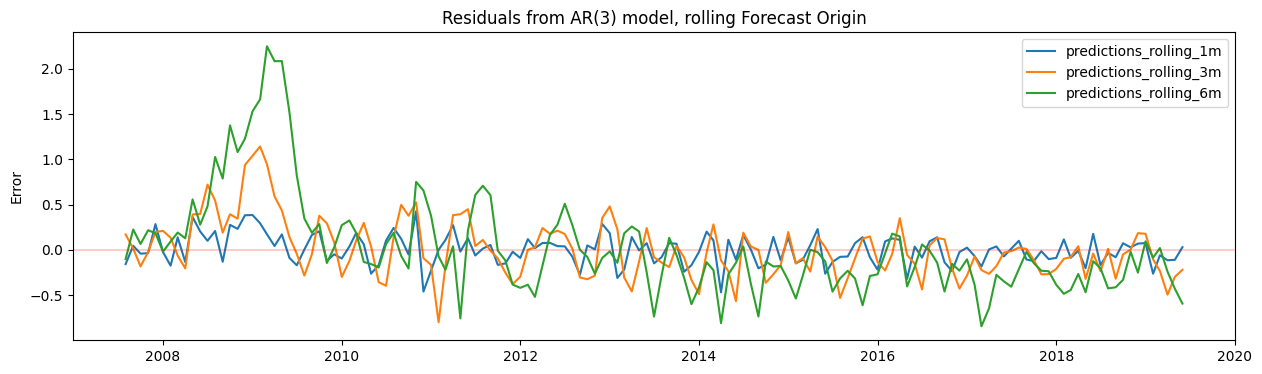

In [89]:
#Plot Residuals
plt.figure(figsize=(15,4))
plt.plot(residuals_rolling_1m)
plt.plot(residuals_rolling_3m)
plt.plot(residuals_rolling_6m)
plt.legend(("predictions_rolling_1m","predictions_rolling_3m", "predictions_rolling_6m"))
plt.title("Residuals from AR(3) model, rolling Forecast Origin")
plt.ylabel("Error")
plt.axhline(0,color='r',alpha=0.2)
plt.show()

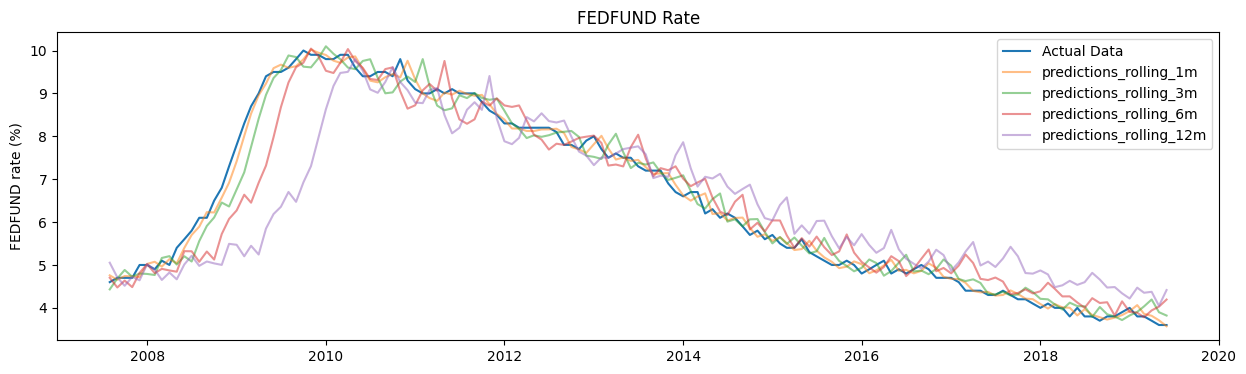

In [90]:
# Plot Predicted vs Actual
plt.figure(figsize=(15,4))
plt.plot(test_data)
plt.plot(predictions_rolling_1m, alpha=0.5)
plt.plot(predictions_rolling_3m, alpha=0.5)
plt.plot(predictions_rolling_6m, alpha=0.5)
plt.plot(predictions_rolling_12m, alpha=0.5)
plt.legend(("Actual Data", "predictions_rolling_1m","predictions_rolling_3m", "predictions_rolling_6m","predictions_rolling_12m"))
plt.title("Monthly Change in FEDFUND Rate")
plt.ylabel("Monthly Change %)")
plt.show()

In [91]:
# 1-month horizon
mape_1m, rmse_1m, mae1m= calculate_performance_metrics(residuals_rolling_1m, test_data)
print("1-Month Horizon - MAPE:", mape_1m, "%, RMSE:", rmse_1m,", MAE:",mae1m )

# 3-month horizon
mape_3m, rmse_3m, mae3m = calculate_performance_metrics(residuals_rolling_3m, test_data)
print("3-Month Horizon - MAPE:", mape_3m, "%, RMSE:", rmse_3m,", MAE:",mae3m )

# 6-month horizon
mape_6m, rmse_6m, mae6m= calculate_performance_metrics(residuals_rolling_6m, test_data)
print("6-Month Horizon - MAPE:", mape_6m, "%, RMSE:", rmse_6m,", MAE:",mae6m )

# 12-month horizon
mape_12m, rmse_12m, mae12m = calculate_performance_metrics(residuals_rolling_12m, test_data)
print("12-Month Horizon - MAPE:", mape_12m, "%, RMSE:", rmse_12m,", MAE:",mae12m )

1-Month Horizon - MAPE: 0.0213 %, RMSE: 0.0265 , MAE: 0.1308
3-Month Horizon - MAPE: 0.038 %, RMSE: 0.0997 , MAE: 0.2398
6-Month Horizon - MAPE: 0.0588 %, RMSE: 0.2999 , MAE: 0.372
12-Month Horizon - MAPE: 0.1172 %, RMSE: 1.1659 , MAE: 0.7408


# ARMA Model:

In [50]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

#Choose optimal lag
bic_values = []
mas = range(1, 12)  # Maximum ma of 12

for ma in mas:
    model = ARIMA(train_data, order=(optimal_lag,0,ma))
    model_fitted = model.fit()
    bic_values.append(model_fitted.bic)

# Selecting the model with the lowest BIC
optimal_ma = mas[np.argmin(bic_values)]
print(f"Optimal ma length: {optimal_ma} with BIC: {min(bic_values)}")

# Create AR Model
model = ARIMA(train_data, order=(optimal_lag,0,optimal_ma))
#fit the model
model_fit = model.fit()
#Model Summary
print(model_fit.summary())

/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive para

Optimal ma length: 1 with BIC: -375.4880208826459
                               SARIMAX Results                                
Dep. Variable:                 UNRATE   No. Observations:                  582
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 210.027
Date:                Thu, 07 Mar 2024   AIC                           -406.053
Time:                        16:38:24   BIC                           -375.488
Sample:                    01-01-1959   HQIC                          -394.139
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.015     -0.200      0.841      -0.032       0.026
ar.L1          0.1536      0.254      0.605      0.545      -0.344       0.651
ar

In [51]:
#Create Model
predictions_rolling_1m = pd.Series()
predictions_rolling_3m = pd.Series()
predictions_rolling_6m = pd.Series()
predictions_rolling_12m = pd.Series()
for end_date in test_data.index:
#Prediction start and end dates
    #1month
    train_data_1m = fedfund[:end_date - pd.DateOffset(months=1)]
    model1 = ARIMA(train_data_1m, order=(optimal_lag,0,optimal_ma))
    model_fit1 = model1.fit()
    pred1 = model_fit1.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_1m.loc[end_date] = pred1.loc[end_date]

    #3month
    train_data_3m = fedfund[:end_date - pd.DateOffset(months=3)]
    model3 = ARIMA(train_data_3m, order=(optimal_lag,0,optimal_ma))
    model_fit3 = model3.fit()
    pred3 = model_fit3.predict(start=test_data.index[0], end = end_date)
    predictions_rolling_3m.loc[end_date] = pred3.loc[end_date]

#    #6month
#    train_data_6m = fedfund[:end_date - pd.DateOffset(months=6)]
#    model6 = ARIMA(train_data_6m, order=(optimal_lag,0,optimal_ma))
#    model_fit6 = model6.fit()
#    pred6 = model_fit6.predict(start=test_data.index[0], end = end_date)
#    predictions_rolling_6m.loc[end_date] = pred6.loc[end_date]###
    

#    #12month
#    train_data_12m = fedfund[:end_date - pd.DateOffset(months=12)]
#    model12 = ARIMA(train_data_12m, order=(optimal_lag,0,optimal_ma))
#    model_fit12 = model12.fit()
#    pred12 = model_fit12.predict(start=test_data.index[0], end = end_date)
#    predictions_rolling_12m.loc[end_date] = pred12.loc[end_date]

/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alancherman/Desktop/DATA 2210/ml_final/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st

KeyboardInterrupt: 

In [27]:
#Calculate Residuals
residuals_rolling_1m = test_data - predictions_rolling_1m
residuals_rolling_3m = test_data - predictions_rolling_3m
#residuals_rolling_6m = test_data - predictions_rolling_6m
#residuals_rolling_12m = test_data - predictions_rolling_12m

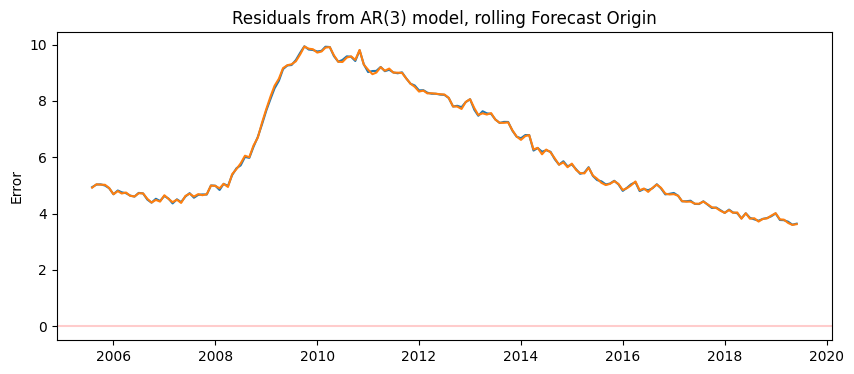

In [28]:
#Plot Residuals
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling_1m)
plt.plot(residuals_rolling_3m)
#plt.plot(residuals_rolling_6m)
#plt.legend(("predictions_rolling_1m","predictions_rolling_3m", "predictions_rolling_6m"))
plt.title("Residuals from AR(3) model, rolling Forecast Origin")
plt.ylabel("Error")
plt.axhline(0,color='r',alpha=0.2)
plt.show()

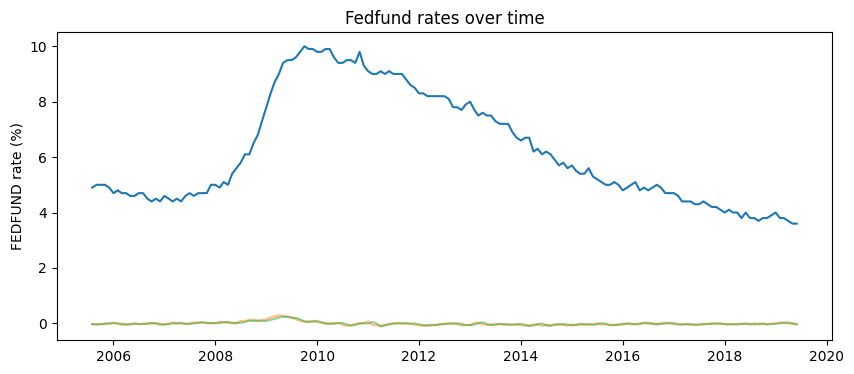

In [29]:
# Plot Predicted vs Actual
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling_1m, alpha=0.5)
plt.plot(predictions_rolling_3m, alpha=0.5)
#plt.plot(predictions_rolling_6m, alpha=0.5)
#plt.legend(("Actual Data", "predictions_rolling_1m","predictions_rolling_3m", "predictions_rolling_6m"))
plt.title("Fedfund rates over time")
plt.ylabel("FEDFUND rate (%)")
plt.show()

In [30]:
# 1-month horizon
mape_1m, rmse_1m = calculate_performance_metrics(residuals_rolling_1m, test_data)
print("1-Month Horizon - MAPE:", mape_1m, "%, RMSE:", rmse_1m)

# 3-month horizon
mape_3m, rmse_3m = calculate_performance_metrics(residuals_rolling_3m, test_data)
print("3-Month Horizon - MAPE:", mape_3m, "%, RMSE:", rmse_3m)

# 6-month horizon
#mape_6m, rmse_6m = calculate_performance_metrics(residuals_rolling_6m, test_data)
#print("6-Month Horizon - MAPE:", mape_6m, "%, RMSE:", rmse_6m)

# 12-month horizon
#mape_12m, rmse_12m = calculate_performance_metrics(residuals_rolling_12m, test_data)
#print("12-Month Horizon - MAPE:", mape_12m, "%, RMSE:", rmse_12m)

1-Month Horizon - MAPE: 1.0017 %, RMSE: 6.546066608698211
3-Month Horizon - MAPE: 1.0016 %, RMSE: 6.5453674036709115
